# Libraries and dataset

In [ ]:
# libraries

import numpy as np 
import pandas as pd 

# text processing 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ML
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
spam = pd.read_csv("../../../datasets/spamham.csv")
spam

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [ ]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


# EDA

## initial cleaning

In [ ]:
# missing values

spam.isna().sum()

text    0
spam    0
dtype: int64

In [ ]:
# duplicates

spam.duplicated().sum()

33

In [ ]:
spam.drop_duplicates(inplace=True)

In [ ]:
spam.duplicated().sum()

0

## exploring the target column

In [ ]:
spam.spam.value_counts()

0    4327
1    1368
Name: spam, dtype: int64

In [ ]:
spam.spam.value_counts(normalize=True)

0    0.759789
1    0.240211
Name: spam, dtype: float64

<AxesSubplot:ylabel='spam'>

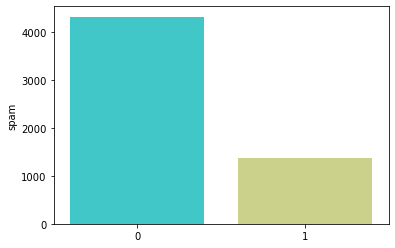

In [ ]:
# visualise the target column

sns.barplot(spam.spam.value_counts().index, spam.spam.value_counts(), palette="rainbow")

In [ ]:
spam[spam.spam ==1 ]["text"] # flagged as spam

0       Subject: naturally irresistible your corporate...
1       Subject: the stock trading gunslinger  fanny i...
2       Subject: unbelievable new homes made easy  im ...
3       Subject: 4 color printing special  request add...
4       Subject: do not have money , get software cds ...
                              ...                        
1363    Subject: are you ready to get it ?  hello !  v...
1364    Subject: would you like a $ 250 gas card ?  do...
1365    Subject: immediate reply needed  dear sir ,  i...
1366    Subject: wanna see me get fisted ?  fist  bang...
1367    Subject: hot stock info : drgv announces anoth...
Name: text, Length: 1368, dtype: object

In [ ]:
spam[spam.spam ==0 ]["text"] # flagged as not spam

1368    Subject: hello guys ,  i ' m " bugging you " f...
1369    Subject: sacramento weather station  fyi  - - ...
1370    Subject: from the enron india newsdesk - jan 1...
1371    Subject: re : powerisk 2001 - your invitation ...
1372    Subject: re : resco database and customer capt...
                              ...                        
5723    Subject: re : research and development charges...
5724    Subject: re : receipts from visit  jim ,  than...
5725    Subject: re : enron case study update  wow ! a...
5726    Subject: re : interest  david ,  please , call...
5727    Subject: news : aurora 5 . 2 update  aurora ve...
Name: text, Length: 4327, dtype: object

In [ ]:
spam

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [ ]:
spam.loc[spam["text"].str.contains("free")]

,text,spam
13,Subject: wall street phenomenon reaps rewards ...,1
19,Subject: 21 st century web specialists jrgbm ...,1
21,Subject: re : wearable electronics hi my name...,1
31,Subject: [ ilug ] seeking your partnership de...,1
32,Subject: [ ilug ] guaranteed to lose 10 - 12 l...,1
...,...,...
5630,Subject: membership mixer tomorrow - paesanos ...,0
5651,"Subject: re : from vicky windsor vicky , ple...",0
5653,Subject: freese notis mike : we are currentl...,0
5667,"Subject: re : info help . krishna , niclas i...",0


# text preprocessing

## data cleaning 

In [ ]:
spam

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [ ]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text

In [ ]:
# Applying the cleaning function to both pred and training datasets
spam['text2'] = spam['text'].apply(lambda x: clean_text(x))

In [ ]:
spam

,text,spam,text2
0,Subject: naturally irresistible your corporate...,1,subject naturally irresistible your corporate ...
1,Subject: the stock trading gunslinger fanny i...,1,subject the stock trading gunslinger fanny is...
2,Subject: unbelievable new homes made easy im ...,1,subject unbelievable new homes made easy im w...
3,Subject: 4 color printing special request add...,1,subject color printing special request addit...
4,"Subject: do not have money , get software cds ...",1,subject do not have money get software cds fr...
...,...,...,...
5723,Subject: re : research and development charges...,0,subject re research and development charges t...
5724,"Subject: re : receipts from visit jim , than...",0,subject re receipts from visit jim thanks ...
5725,Subject: re : enron case study update wow ! a...,0,subject re enron case study update wow all ...
5726,"Subject: re : interest david , please , call...",0,subject re interest david please call shi...


In [ ]:
spam['text2'] = spam['text2'].apply(lambda x: re.sub("subject ", "", x))

In [ ]:
spam

,text,spam,text2
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...
3,Subject: 4 color printing special request add...,1,color printing special request additional in...
4,"Subject: do not have money , get software cds ...",1,do not have money get software cds from here ...
...,...,...,...
5723,Subject: re : research and development charges...,0,re research and development charges to gpg h...
5724,"Subject: re : receipts from visit jim , than...",0,re receipts from visit jim thanks again fo...
5725,Subject: re : enron case study update wow ! a...,0,re enron case study update wow all on the s...
5726,"Subject: re : interest david , please , call...",0,re interest david please call shirley cre...


In [ ]:
spam['text2'] = spam['text2'].apply(lambda x: re.sub("re ", "", x))

In [ ]:
spam

,text,spam,text2
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...
3,Subject: 4 color printing special request add...,1,color printing special request additional in...
4,"Subject: do not have money , get software cds ...",1,do not have money get softwacds from he soft...
...,...,...,...
5723,Subject: re : research and development charges...,0,research and development charges to gpg heit...
5724,"Subject: re : receipts from visit jim , than...",0,receipts from visit jim thanks again for t...
5725,Subject: re : enron case study update wow ! a...,0,enron case study update wow all on the same...
5726,"Subject: re : interest david , please , call...",0,interest david please call shirley crensh...


In [ ]:
# text preprocessing function
def text_preprocessing(text, list_words):
    """
    Cleaning and parsing the text.
    """
    
    # 2. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    # 3. Remove punctuations and stopwords
    tokens = tokenizer.tokenize(text)
    
    # 4. Update the stop_words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(list_words)
    
    
    remove_stopwords = [w for w in tokens if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [ ]:
list_words = ["û", "u","dont", "im", "one", "amp", "new"]

In [ ]:
spam

,text,spam,text2
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...
3,Subject: 4 color printing special request add...,1,color printing special request additional in...
4,"Subject: do not have money , get software cds ...",1,do not have money get softwacds from he soft...
...,...,...,...
5723,Subject: re : research and development charges...,0,research and development charges to gpg heit...
5724,"Subject: re : receipts from visit jim , than...",0,receipts from visit jim thanks again for t...
5725,Subject: re : enron case study update wow ! a...,0,enron case study update wow all on the same...
5726,"Subject: re : interest david , please , call...",0,interest david please call shirley crensh...


In [ ]:
spam['text3'] = spam['text2'].apply(lambda x : text_preprocessing(x, list_words))

In [ ]:
spam

,text,spam,text2,text3
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...,naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...,stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...,unbelievable homes made easy wanting show home...
3,Subject: 4 color printing special request add...,1,color printing special request additional in...,color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1,do not have money get softwacds from he soft...,money get softwacds softwacompatibility great ...
...,...,...,...,...
5723,Subject: re : research and development charges...,0,research and development charges to gpg heit...,research development charges gpg heit forwarde...
5724,"Subject: re : receipts from visit jim , than...",0,receipts from visit jim thanks again for t...,receipts visit jim thanks invitation visit lsu...
5725,Subject: re : enron case study update wow ! a...,0,enron case study update wow all on the same...,enron case study update wow day super thank mu...
5726,"Subject: re : interest david , please , call...",0,interest david please call shirley crensh...,interest david please call shirley crenshaw as...


## wordcloud

In [ ]:
spamemails = spam[spam.spam ==1]["text3"]
notspamemails = spam[spam.spam ==0]["text3"]

In [ ]:
spamemails

0       naturally irresistible corporate identity lt r...
1       stock trading gunslinger fanny merrill muzo co...
2       unbelievable homes made easy wanting show home...
3       color printing special request additional info...
4       money get softwacds softwacompatibility great ...
                              ...                        
1363    ayou ready get hello viagra med struggle mens ...
1364    would like gas card let current high price gas...
1365    immediate reply needed dear sir dr james alabi...
1366    wanna see get fisted fist bang show everything...
1367    hot stock info drgv announces another press re...
Name: text3, Length: 1368, dtype: object

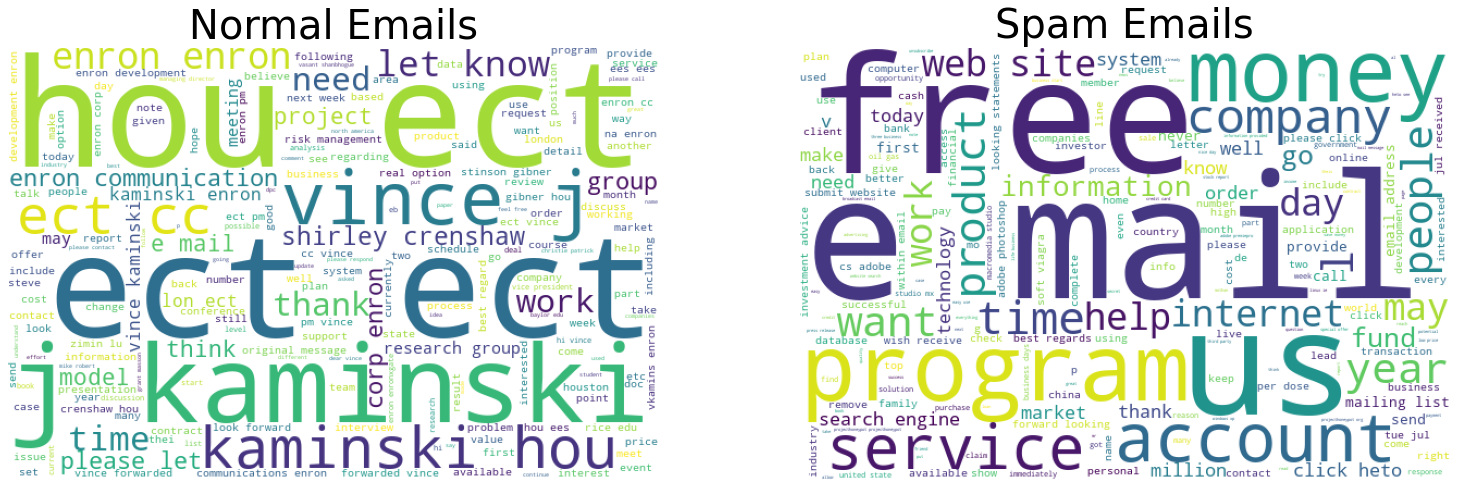

In [ ]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(notspamemails))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Normal Emails',fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(spamemails))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Spam Emails',fontsize=40);

# Vectorizing

## BOW

In [ ]:
count_vectorizer = CountVectorizer(max_features = 1500)

bow_vectors = count_vectorizer.fit_transform(spam['text3'])

bow_vectors

<5695x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 311241 stored elements in Compressed Sparse Row format>

In [ ]:
bow_vectors.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int64)

## TFIDF

In [ ]:
tfidf = TfidfVectorizer(max_features=1500)

tfidf = TfidfVectorizer(max_features=1500, min_df=2,
                       max_df=0.5, ngram_range=(1, 2))

tfidf_vectors = tfidf.fit_transform(spam['text3'])

tfidf_vectors

<5695x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 334887 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_vectors.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15597622, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Building a classification Model - Log reg

In [ ]:
# Execute this line (of course, modifying the path)
import sys
sys.path.insert(0, 'fx_MLClassification')

from fx_MLClassification import *

## fitting a  log reg on BOW

In [ ]:
y = spam.spam
X = bow_vectors

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=42)

In [ ]:
X_train

<3986x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 220605 stored elements in Compressed Sparse Row format>

In [ ]:
X_train.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 9],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
LR = LogisticRegression()

LRbow = LR.fit(X_train, y_train)

In [ ]:
# make predictions

y_pred = LRbow.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
C_Allmetrics(LRbow, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3057    1]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1257   12]
 [  14  426]]
 Classification report 
    precision    recall  f1-score  support
0   0.988985  0.990544  0.989764   1269.0
1   0.972603  0.968182  0.970387    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.986200   0.978236  0.983494  0.980804
test   0.984786   0.980794  0.979363  0.980076


,Accuracy,Precision,Recall,f1
Train,0.986200,0.978236,0.983494,0.980804
test,0.984786,0.980794,0.979363,0.980076


## fitting a log reg on TFIDF

In [ ]:
y = spam.spam
Xt = tfidf_vectors

X_trainT,X_testT,y_trainT,y_testT = train_test_split(Xt,y,test_size=0.3,
                                                 random_state=42)


In [ ]:
LR = LogisticRegression()

LRtfidf = LR.fit(X_trainT, y_trainT)

In [ ]:
# make predictions

y_predT = LRtfidf.predict(X_testT)
y_predT

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
C_Allmetrics(LRtfidf, X_trainT, y_trainT, X_testT, y_testT)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3047   11]
 [  25  903]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1260    9]
 [  37  403]]
 Classification report 
    precision    recall  f1-score  support
0   0.971473  0.992908  0.982073   1269.0
1   0.978155  0.915909  0.946009    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.977666   0.977174  0.959929  0.968111
test   0.973084   0.974814  0.954408  0.964041


,Accuracy,Precision,Recall,f1
Train,0.977666,0.977174,0.959929,0.968111
test,0.973084,0.974814,0.954408,0.964041


In [ ]:
# slightly worse than log reg with bow

# Build a classif model - random forest

## random forest on BOW

In [ ]:
#instantiate
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
#fit
RFbow = rand_forest.fit(X_train, y_train)


In [ ]:
#predict and check
y_pred_RFbow = RFbow.predict(X_test)

In [ ]:
y_pred_RFbow

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
C_Allmetrics(RFbow, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3057    1]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1259   10]
 [  12  428]]
 Classification report 
    precision    recall  f1-score  support
0   0.990559  0.992120  0.991339   1269.0
1   0.977169  0.972727  0.974943    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.981686   0.974065  0.974951  0.974419
test   0.987127   0.983864  0.982424  0.983141


,Accuracy,Precision,Recall,f1
Train,0.981686,0.974065,0.974951,0.974419
test,0.987127,0.983864,0.982424,0.983141


In [ ]:
# almost the same as log reg on bow but slightly worse

## random forest on TFIDF

In [ ]:
#instantiate
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
#fit
RFtfidf = rand_forest.fit(X_trainT, y_trainT)


In [ ]:
#predict and check
y_pred_RFtfidf = RFtfidf.predict(X_testT)

In [ ]:
y_pred_RFtfidf

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
C_Allmetrics(RFtfidf, X_trainT, y_trainT, X_testT, y_testT)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3057    1]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1257   12]
 [  13  427]]
 Classification report 
    precision    recall  f1-score  support
0   0.989764  0.990544  0.990154   1269.0
1   0.972665  0.970455  0.971559    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.980681   0.972485  0.973925  0.973036
test   0.985372   0.981214  0.980499  0.980856


,Accuracy,Precision,Recall,f1
Train,0.980681,0.972485,0.973925,0.973036
test,0.985372,0.981214,0.980499,0.980856


In [ ]:
# again very close but best is logistic regression with BOW

# Hypertuning

In [ ]:
# params

penalty = ['l1', 'l2'] #type of regularisation technique.
#L2 is called Ridge Regression
#L1 is Lasso

C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#degree of penalization, regularization

class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6},
                {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 
#weigth that you want to give to each of the classes

solver = ['liblinear', 'saga'] 
#Algorithm to use in the optimization problem.
#For small datasets: ‘liblinear’;
# and ‘sag’ and ‘saga’ works faster for large datasets.


In [ ]:
param_grid = dict(penalty=penalty, C=C, 
                  class_weight=class_weight, 
                  solver=solver)

In [ ]:
grid = GridSearchCV(estimator = LRbow, param_grid=param_grid, 
                    scoring="roc_auc",
                    verbose=1, n_jobs=-1, cv=10)

In [ ]:
gridresult = grid.fit(X_train, y_train)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [ ]:
print("best estimator")
print(gridresult.best_estimator_)
print("best score")
print(gridresult.best_score_)

best estimator
LogisticRegression(C=1, class_weight={0: 0.6, 1: 0.4}, solver='liblinear')
best score
0.9970352040473094


In [ ]:
# repeat the model with the best parameters

logregbow2 = LogisticRegression(C=1, class_weight={0: 0.6, 1: 0.4}, solver='liblinear', random_state=42)

In [ ]:
logregbow2.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 0.6, 1: 0.4}, random_state=42,
                   solver='liblinear')

In [ ]:
C_Allmetrics(logregbow2, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3058    0]
 [   3  925]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1260    9]
 [  20  420]]
 Classification report 
    precision    recall  f1-score  support
0   0.984375  0.992908  0.988623   1269.0
1   0.979021  0.954545  0.966628    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.984948   0.979038  0.978941  0.978940
test   0.983031   0.981698  0.973727  0.977626


,Accuracy,Precision,Recall,f1
Train,0.984948,0.979038,0.978941,0.978940
test,0.983031,0.981698,0.973727,0.977626


In [ ]:
# worse than before the hypertunning


# Naive Bayes attempt


## naive bayes with bow

In [ ]:
X = X.toarray()


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5723    0
5724    0
5725    0
5726    0
5727    0
Name: spam, Length: 5695, dtype: int64

In [ ]:
spam

,text,spam,text2,text3
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...,naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill...,stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting t...,unbelievable homes made easy wanting show home...
3,Subject: 4 color printing special request add...,1,color printing special request additional in...,color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1,do not have money get softwacds from he soft...,money get softwacds softwacompatibility great ...
...,...,...,...,...
5723,Subject: re : research and development charges...,0,research and development charges to gpg heit...,research development charges gpg heit forwarde...
5724,"Subject: re : receipts from visit jim , than...",0,receipts from visit jim thanks again for t...,receipts visit jim thanks invitation visit lsu...
5725,Subject: re : enron case study update wow ! a...,0,enron case study update wow all on the same...,enron case study update wow day super thank mu...
5726,"Subject: re : interest david , please , call...",0,interest david please call shirley crensh...,interest david please call shirley crenshaw as...


In [ ]:
#split the data
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,
                                                 random_state=42)

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

#Create a Gaussian Classifier
mnb = GaussianNB()

#Train the model using the training sets
mnb.fit(Xtrain, ytrain)

#Predict the response for test dataset
y_predNB = mnb.predict(Xtest)

In [ ]:
y_predNB

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
C_Allmetrics(mnb, Xtrain, ytrain, Xtest, ytest)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[2838  220]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1174   95]
 [  25  415]]
 Classification report 
    precision    recall  f1-score  support
0   0.979149  0.925138  0.951378   1269.0
1   0.813725  0.943182  0.873684    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.932509   0.893985  0.932006  0.910268
test   0.929783   0.896437  0.934160  0.912531


,Accuracy,Precision,Recall,f1
Train,0.932509,0.893985,0.932006,0.910268
test,0.929783,0.896437,0.934160,0.912531


# Instructor notes